In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data

import viz_weights
%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
style.set_style()

# load results from a directory

In [2]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/sweep_full_real'
fnames = sorted([fname for fname in os.listdir(out_dir)
                 if not 'mnist' in fname]) # and 
#                  'numlays=4' in fname and 
#                  'batchsize=100' in fname and 
#                  not 'batchsize=1000' in fname])
weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if fname.startswith('weights')]
results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights')]
results = pd.concat(results_list, axis=1).T.infer_objects()

save_dir = 'results_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
print('loaded', results_weights.shape[0], 'runs')

100%|██████████| 668/668 [00:47<00:00, 14.11it/s]

loaded 334 runs


# run all max corrs

In [ ]:
# preprocess data
def process_loaders(train_loader, test_loader):
    # need to load like this to ensure transformation applied
    data_list_train = [batch for batch in train_loader]
    train_data_list = [batch[0] for batch in data_list_train]
    train_data = np.vstack(train_data_list)
    X_train = torch.Tensor(train_data).float().cuda()
    Y_train = np.hstack([batch[1] for batch in data_list_train])

    data_list_test = [batch for batch in test_loader]
    test_data_list = [batch[0] for batch in data_list_test]
    test_data = np.vstack(test_data_list)
    X_test = torch.Tensor(test_data).float().cuda()
    Y_test = np.hstack([batch[1] for batch in test_data_list])
    
    return X_train, Y_train, X_test, Y_test

# gives max corr between nearest neighbor and any point
# works clearly for 1st layer, for 2nd layers have to generate a "filter" by doing max activation
# X is N x num_pixels
# W is num_filters x num_pixels
# returns max_corr for each filter
def max_corr_input(X, W):
#     print(X.shape, W.shape)
    X = X / (np.sum(np.abs(X)**2, axis=1)**(1./2))[:, np.newaxis]
    W = W / (np.sum(np.abs(W)**2, axis=1)**(1./2))[:, np.newaxis]
    Z = np.abs(W @ X.T)
    max_corr = np.max(Z, axis=1)
    return max_corr

# calc corr score from run
def calc_max_corr_input(run, X_train, Y_train):
    
    # keys are epochs, vals are dicts of all weights
    weights_dict_dict = run['weights']

    # keys are layers, vals are weight values
    weights_dict = weights_dict_dict[epoch]
    
    # load model
    model = data.get_model(run)

    # load in weights
    weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
    model.load_state_dict(weights_dict_tensors)
    model = model.cuda()
    
    preds = model(Variable(X_train)).data.cpu().numpy().argmax(axis=1)
    accs = preds==Y_train
    
    X = X_train.cpu().numpy().reshape(X_train.shape[0], -1)
    W = model.state_dict()['fc.0.weight'].cpu().numpy()
    max_corr = max_corr_input(X, W)
    
    return np.mean(max_corr), np.mean(accs)

results_weights = results_weights[results_weights['shuffle_labels'] == False]
results_weights = results_weights[results_weights['seed'] == 0]
                                  
N = results_weights.shape[0]
epoch = 151
mean_max_corrs, train_accs = np.zeros(N), np.zeros(N)
train_loader, test_loader = data.get_data_loaders(results_weights.iloc[0])
X_train, Y_train, X_test, Y_test = process_loaders(train_loader, test_loader)
for i in tqdm(range(N)):
    run = results_weights.iloc[i]
    run['num_layer'] = int(run['num_layers'])
    run['hidden_size'] = int(run['hidden_size'])
    mean_max_corrs[i], train_accs[i] = calc_max_corr_input(run, X_train, Y_train)

 10%|▉         | 5/52 [00:56<08:57, 11.43s/it]

In [85]:
pd_max = pd.DataFrame({'max_corr': mean_max_corrs, 'train_acc_final': train_accs})
pd_max.to_pickle('max_corr.pkl')
# pkl.dump(pd_max, 'max_corr_small.pkl')

In [ ]:
plt.plot(train_accs, mean_max_corrs, 'o')

# set the params

In [54]:
row = 7
epoch = 151
lay = 'fc.0.weight'
num_to_plot = 225
# vs = {'lr': 0.01, 'seed': 0, 'optimizer': 'adam'}
vs = {'lr': 0.01, 'seed': 0, 'optimizer': 'sgd'}

# filter out certain things
results_weights = results_weights[results_weights['shuffle_labels'] == False]

# filter appropriate run
run = results_weights[(results_weights['lr'] == vs['lr'])]
run = run[(run['optimizer'] == vs['optimizer'])]
run = run[(run['seed'] == vs['seed'])]

# load corresponding accs
run_accs = results[(results['lr'] == vs['lr'])]
run_accs = run_accs[(run_accs['optimizer'] == vs['optimizer'])]
run_accs = run_accs[(run_accs['seed'] == vs['seed'])]
# plt.plot(run_accs['its'], run_accs['accs_train'])
# print(run_accs['accs_train'][:30])


# cast variables to correct types
run = run.iloc[0]
run['num_layer'] = int(run['num_layers'])
run['hidden_size'] = int(run['hidden_size'])

### plot weights

In [62]:
# keys are epochs, vals are dicts of all weights
weights_dict_dict = run['weights']

# keys are layers, vals are weight values
weights_dict = weights_dict_dict[epoch]

# matrix of weights (output x input
w = weights_dict[lay]

# viz_weights.plot_weights(w[:num_to_plot])
# plt.show()

### reload the model

In [56]:
# load model
train_loader, test_loader, model, trans = data.get_data_and_model(run)

# load in weights
weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
model.load_state_dict(weights_dict_tensors)
model = model.cuda()

### reload the data

In [64]:

X_train, Y_train, X_test, Y_test = process_loaders(train_loader, test_loader)

### check the acc

In [58]:
preds = model(Variable(X_train)).data.cpu().numpy().argmax(axis=1)
accs = preds==Y_train
print('mean acc', np.mean(accs))

mean acc 0.98355


In [59]:
'''
mean_accs = np.zeros(10)
for c in range(10):
    idxs_c = Y_train == c
    mean_accs[c] = np.mean(accs[idxs_c])
plt.plot(range(10), mean_accs, 'o')
plt.xlabel('class')
plt.ylabel('acc')
'''

"\nmean_accs = np.zeros(10)\nfor c in range(10):\n    idxs_c = Y_train == c\n    mean_accs[c] = np.mean(accs[idxs_c])\nplt.plot(range(10), mean_accs, 'o')\nplt.xlabel('class')\nplt.ylabel('acc')\n"

mean max corr 0.1759335


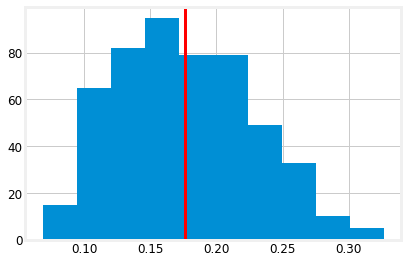

In [61]:
X = X_train.cpu().numpy().reshape(X_train.shape[0], -1)
W = model.state_dict()['fc.0.weight'].cpu().numpy()
max_corr = max_corr_input(X, W)
print('mean max corr', np.mean(max_corr))
plt.hist(max_corr)
plt.axvline(np.mean(max_corr), color='red')
plt.show()